# IRIS dataset regression

#### 1. Data load and check

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from sklearn.datasets import load_iris
# iris dataset load (internal dataset)
iris = load_iris()

# DF 
X = pd.DataFrame(iris.data,columns=iris.feature_names)
y = pd.Series(iris.target, name='target')

# data shape
# 데이터 형태 확인
print(f"Feature matrix shape: {X.shape}")
print(f"Target vector shape: {y.shape}")

# 데이터 상위 5개 행 확인
print("\nData preview:")
print(X.head())

# 타겟 분포 확인 (클래스 불균형 여부 등 확인)
print("\nTarget distribution:")
print(y.value_counts())

# 데이터 정보 확인 (결측치, 타입 등 확인)
print("\nData info:")
print(X.info())

Feature matrix shape: (150, 4)
Target vector shape: (150,)

Data preview:
   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)
0                5.1               3.5                1.4               0.2
1                4.9               3.0                1.4               0.2
2                4.7               3.2                1.3               0.2
3                4.6               3.1                1.5               0.2
4                5.0               3.6                1.4               0.2

Target distribution:
target
0    50
1    50
2    50
Name: count, dtype: int64

Data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sepal length (cm)  150 non-null    float64
 1   sepal width (cm)   150 non-null    float64
 2   petal length (cm)  150 non-null    float64
 3   petal width (cm)   150 non-nul

#### 2. NaN Check and EDA

Missing values per column:
sepal length (cm)    9
sepal width (cm)     9
petal length (cm)    9
petal width (cm)     9
dtype: int64


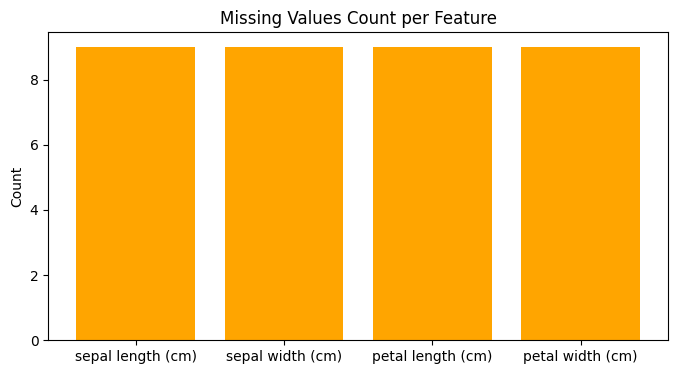


After imputation, missing values:
sepal length (cm)    0
sepal width (cm)     0
petal length (cm)    0
petal width (cm)     0
dtype: int64


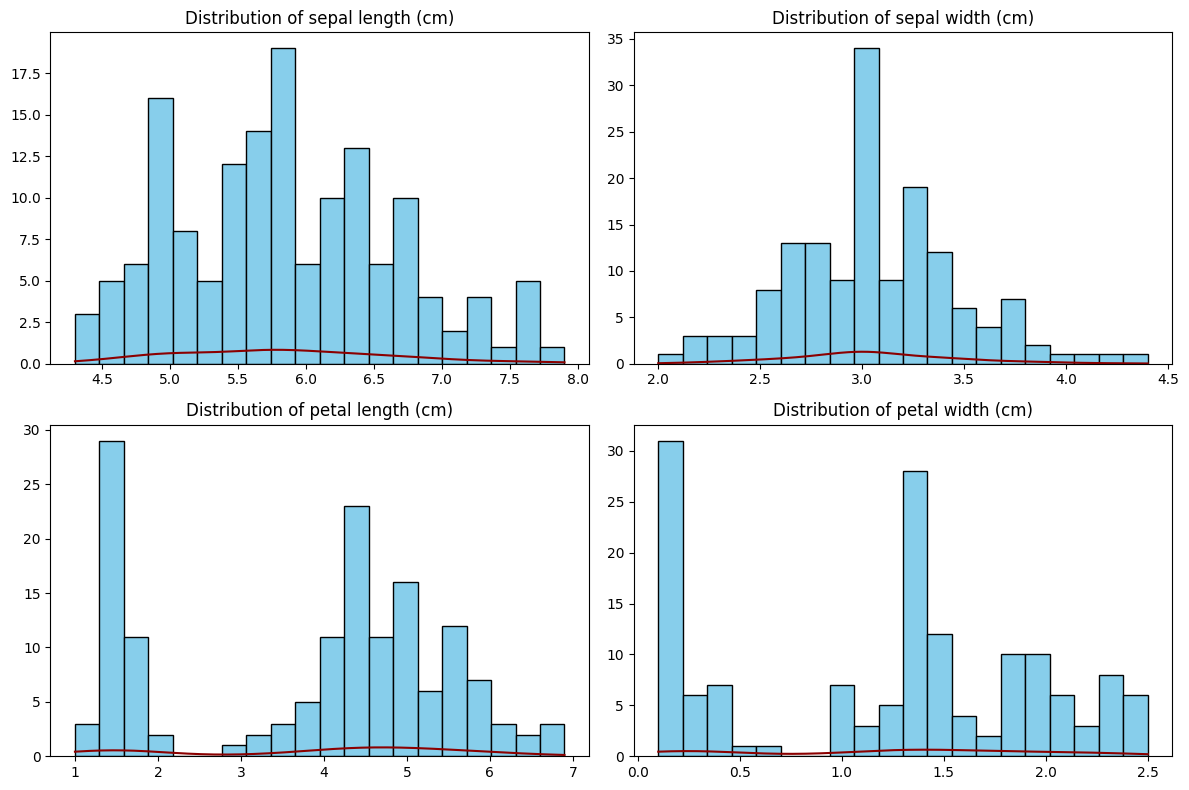

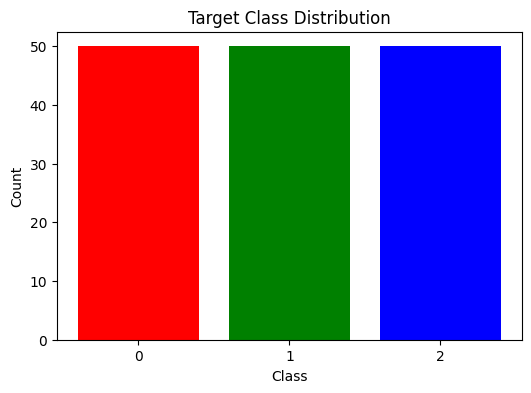

In [3]:
from scipy.stats import gaussian_kde 

# 인위적으로 결측치 추가 (실제 결측치가 없으므로 실습을 위해 5% 정도 추가)
np.random.seed(42)
X_missing = X.copy()
for col in X_missing.columns:
    mask = np.random.rand(len(X_missing)) < 0.05
    X_missing.loc[mask, col] = np.nan 

# NaN Count 
missing_counts = X_missing.isnull().sum() 
print("Missing values per column:")
print(missing_counts)

# 결측치 시각화 (각 특성별 결측치 개수)
plt.figure(figsize=(8, 4))
plt.bar(missing_counts.index, missing_counts.values, color='orange')
plt.title('Missing Values Count per Feature')
plt.ylabel('Count')
plt.show()
# 결측치 처리: SimpleImputer (중앙값 대체)
# SimpleImputer는 scikit-learn의 결측치 대체 도구로, 수치형 데이터의 결측치를 평균/중앙값/최빈값 등으로 채울 수 있음
from sklearn.impute import SimpleImputer 

imputer = SimpleImputer(strategy='median') 
X_imputed = pd.DataFrame(imputer.fit_transform(X_missing),columns=X_missing.columns) 

# 결측치 처리 후 확인
print("\nAfter imputation, missing values:")
print(X_imputed.isnull().sum())

# EDA: 각 특성의 분포 시각화
plt.figure(figsize=(12, 8))
for i, col in enumerate(X_imputed.columns):
    plt.subplot(2, 2, i+1)
    data = X_imputed[col]
    plt.hist(data, bins=20, color='skyblue', edgecolor='black')
    # KDE 곡선 추가 (분포 모양 파악)
    kde = gaussian_kde(data)
    x_vals = np.linspace(data.min(), data.max(), 300)
    plt.plot(x_vals, kde(x_vals)*len(data)*(x_vals[1]-x_vals[0]), color='darkred')
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

# 타겟 분포 시각화 (클래스별 샘플 수)
plt.figure(figsize=(6, 4))
plt.bar(y.value_counts().index.astype(str), y.value_counts().values, color=['red', 'green', 'blue'])
plt.title('Target Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()


#### 3. Preprocessing (scaling, encoding)

In [4]:
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder 
from sklearn.compose import ColumnTransformer 
from sklearn.pipeline import Pipeline 

# LabelEncoder: 타겟 변수가 이미 숫자이지만, 명확하게 인코딩 (범주형일 때 필수)
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# OneHotEncoder: 범주형 변수를 더미 변수로 변환 (iris 데이터는 모두 수치형이지만 예시로 petal width를 범주화)
X_pre = X_imputed.copy()
X_pre['petal width category'] = pd.cut(X_pre['petal width (cm)'], bins=3, labels=['small', 'medium', 'large'])

# 수치형, 범주형 특성 구분 (select_dtypes를 사용해서 자동 분류)
numeric_features = X_pre.select_dtypes(include=['float64']).columns.tolist() 
categorical_features = ['petal width category'] 

# pipeline
numeric_transformer = Pipeline(steps=[
    ('scaler',StandardScaler())
])
categorical_transformer = Pipeline(steps=[
    ('onehot',OneHotEncoder(drop='first',sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers = [
        ('num',numeric_transformer, numeric_features),
        ('cat',categorical_transformer,categorical_features) 
    ]
)

# 전처리 적용
X_processed = preprocessor.fit_transform(X_pre) 

# 전처리 후 특성 이름  -> optional 
encoded_cat_features = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)
feature_names = numeric_features + list(encoded_cat_features)

print(f"Processed feature matrix shape: {X_processed.shape}")
print(f"Feature names: {feature_names}")


Processed feature matrix shape: (150, 6)
Feature names: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)', 'petal width category_medium', 'petal width category_small']


#### 4. Model select and fitting

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# 훈련/테스트 데이터 분할 (stratify로 클래스 비율 유지)
X_train, X_test, y_train, y_test = train_test_split(X_processed, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

# 다양한 모델 정의 (Logistic Regression, Random Forest)
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42)
}

# 모델 학습 및 평가 결과 저장
results = {}

for name, model in models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"{name} Accuracy: {acc:.4f}")
    print(classification_report(y_test, y_pred))
    results[name] = model



Training Logistic Regression...
Logistic Regression Accuracy: 0.9667
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       0.91      1.00      0.95        10
           2       1.00      0.90      0.95        10

    accuracy                           0.97        30
   macro avg       0.97      0.97      0.97        30
weighted avg       0.97      0.97      0.97        30


Training Random Forest...
Random Forest Accuracy: 0.9333
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       0.83      1.00      0.91        10
           2       1.00      0.80      0.89        10

    accuracy                           0.93        30
   macro avg       0.94      0.93      0.93        30
weighted avg       0.94      0.93      0.93        30



#### 5. Prediction

In [5]:
# 이미 위에서 함

#### 6. Feature engineering


Tuning Logistic Regression...
Best params: {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
Best CV accuracy: 0.9583

Tuning Random Forest...
Best params: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 50}
Best CV accuracy: 0.9583

Best model after tuning: Logistic Regression
Test accuracy of best model: 0.9667
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       0.91      1.00      0.95        10
           2       1.00      0.90      0.95        10

    accuracy                           0.97        30
   macro avg       0.97      0.97      0.97        30
weighted avg       0.97      0.97      0.97        30



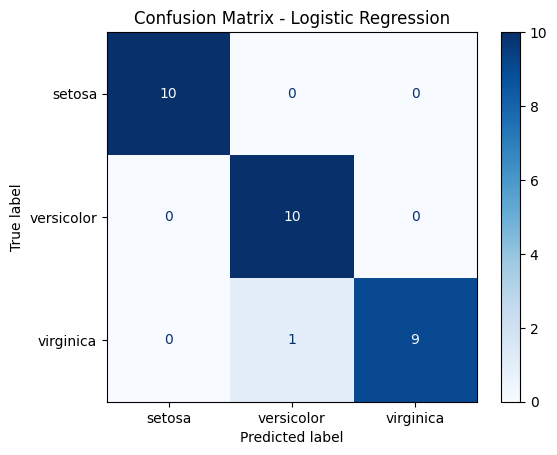


Best model saved as 'iris_best_model.pkl'


In [13]:
# 6. 성능 개선: 하이퍼파라미터 튜닝 (GridSearchCV 사용)
from sklearn.model_selection import GridSearchCV

# Logistic Regression 하이퍼파라미터 그리드
param_grid_lr = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l2'],
    'solver': ['lbfgs']
}

# Random Forest 하이퍼파라미터 그리드
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# Logistic Regression 튜닝
print("\nTuning Logistic Regression...")
grid_lr = GridSearchCV(LogisticRegression(max_iter=1000, random_state=42), param_grid_lr, cv=5, scoring='accuracy', n_jobs=-1)
grid_lr.fit(X_train, y_train)
print(f"Best params: {grid_lr.best_params_}")
print(f"Best CV accuracy: {grid_lr.best_score_:.4f}")

# Random Forest 튜닝
print("\nTuning Random Forest...")
grid_rf = GridSearchCV(RandomForestClassifier(random_state=42), param_grid_rf, cv=5, scoring='accuracy', n_jobs=-1)
grid_rf.fit(X_train, y_train)
print(f"Best params: {grid_rf.best_params_}")
print(f"Best CV accuracy: {grid_rf.best_score_:.4f}")

# 최적 모델 선택
best_model_name = 'Logistic Regression' if grid_lr.best_score_ >= grid_rf.best_score_ else 'Random Forest'
best_model = grid_lr.best_estimator_ if best_model_name == 'Logistic Regression' else grid_rf.best_estimator_
print(f"\nBest model after tuning: {best_model_name}")

# 테스트 데이터에 대해 최적 모델 평가
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred_best = best_model.predict(X_test)
acc_best = accuracy_score(y_test, y_pred_best)
print(f"Test accuracy of best model: {acc_best:.4f}")
print(classification_report(y_test, y_pred_best))

# 혼동 행렬 시각화
cm = confusion_matrix(y_test, y_pred_best)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=iris.target_names)
disp.plot(cmap='Blues')
plt.title(f'Confusion Matrix - {best_model_name}')
plt.show()

# 최종 모델 저장 (joblib: 모델 직렬화/저장 라이브러리)
import joblib
joblib.dump(best_model, 'iris_best_model.pkl')
print("\nBest model saved as 'iris_best_model.pkl'")